# The Smoothed Duality Gap as a Stopping Criterion

This notebook provides the different experiments conducted in order to validate and illustrate our theoretical findings outlined in our paper entitled: ***The Smoothed Duality Gap as a Stopping Criterion***.

**- Abstract:** we optimize the running time of the primal-dual algorithms by optimizing their stopping criteria for solving convex optimization problems under affine equality constraints, which means terminating the algorithm earlier with fewer iterations. We study the relations between four stopping criteria and show under which conditions they are accurate to detect optimal solutions. The uncomputable one: *"Optimality gap and Feasibility error"*, and the computable ones: the *"Karush-Kuhn-Tucker error"*, the *"Projected Duality Gap"*, and the *"Smoothed Duality Gap"*. Assuming metric sub-regularity or quadratic error bound, we establish that all of the computable criteria provide practical upper bounds for the optimality gap, and approximate it effectively. Furthermore, we establish comparability between some of the computable criteria under certain conditions. Numerical experiments on basis pursuit, and quadratic programs with(out) non-negative weights corroborate these findings and show the superior stability of the smoothed duality gap over the rest.

**- Framework of Interest:** we are interested in convex optimization problems under affine equality constraints. That is:

\begin{equation}
    \min_{x \in \mathcal{X}} ~ f(x) \hspace{1cm} \text{subject to} \hspace{1cm} Ax = b
\end{equation}

where $f \colon \mathcal{X} \rightarrow \mathbb{R} \cup \{+\infty\}$ is a proper, lower semi-continuous, and convex function with a computable proximal operator, $A \colon \mathcal{X} \rightarrow \mathcal{Y}$ is a linear operator, and $b \in \mathcal{Y}$. We call it the ***primal problem***

**- Employed Algorithm:** we employ the ***Primal-Dual Hybrid Gradient (PDHG)*** algorithm to solve the associated ***saddle point problem***: 
\begin{equation}
    \min_{x \in \mathcal{X}} \max_{y \in \mathcal{Y}} ~ \mathcal{L}(x, y) := f(x) + \left\langle Ax - b, y \right\rangle 
\end{equation}
where $\mathcal{L}(x, y)$ is the ***associated Lagrangian*** with the primal problem and $y \in \mathcal{Y}$ is the so-called Lagrange multiplier or dual variable.

<center>

|  Algorithm: Primal-Dual Hybrid Gradient (PDHG) |
|-----------------------------------------------|
| $\hspace{1.25cm}\begin{aligned} \bar{x}_{k+1} &= \mathrm{Prox}_{\tau f}\left(x_k - \tau A^Ty_k\right) \\ \bar{y}_{k+1} &= y_k + \sigma \left(A\bar{x}_{k+1} - b\right)\\ x_{k+1} &= \bar{x}_{k+1} - \tau A^T\left(\bar{y}_{k+1} - y_k\right)  \\ y_{k+1} &= \bar{y}_{k+1} \\ \end{aligned}$| 

</center>

with primal and dual step sizes: $\tau = \frac{0.95}{\|A\|}$ and $\sigma = \frac{1}{\|A\|}$, respectively. 

 
**- Conducted Experiments:**
* *Linearly-constrained Least-Squares (LC-LS)*.
  * *One-dimensional* problem. 
  * *I.I.D. Gaussian matrices* problem. 
  * *Non-trivial covariance matrices* problem. 
  * *Distributed optimization* problem. 
* *Quadratic Programming (QP)*. 
*  *Basis Pursuit (BP)*.

**- For each experiment, we do the following:**
* We find the optimal solution of the problem either analytically or by using CVXPY.
* We solve the problem using ***(PDHG)***. 
* We Computed all the measures, presented in Sections 3 and 4: 
  * *Optimality Gap (OG).*
  * *Feasibility Error (FE).* 
  * *Karush–Kuhn–Tucker (KKT) error.* 
  * *Projected Duality Gap (PDG).*
  * *Smoothed Duality Gap (SDG).*
* We compute the optimality gap bounds (approximations), presented in Section 5. 
* We compute the comparability bounds, presented in Section 6.


In [1]:
import numpy as np 

from PDHG import PDHG
from OptimizationBounds import OptimizationBounds, find_iter, avg_sd
from Plotter import Plotter

In [2]:
"""
Initializing two dictionaries to facilitate benchmark comparison at the end. We fill them by
information of each experiment along the notebook. 
    - OG_all: Includes the optimality gap approximations (KKT, PDG, and SDG) for each experiment. 
    - comparability_all: Includes the comparability bounds for each experiment. 
        - KKT approximation for SDG.
        - SDG approximation for KKT.
        - PDG approximation for SDG.
        - SDG approximation for PDG.
"""

OG_all, comparability_all = {}, {}

GK = "SDG ≤ KKT"
KG = "KKT ≤ SDG"
GD = "SDG ≤ PDG"
DG = "PDG ≤ SDG"
comparability = {GK: None, KG: None, GD: None, DG: None}

## Linearly-Constrained Least-Squares (LC-LS)

Our first class of experiments is the ***Linearly-Constrained Least-Squares (LC-LS)*** class presented in Sub-section **7.1**. 

\begin{equation} 
    \min_{x \in \mathbb{R}^n} ~  \frac{1}{2} \|Qx - c\|^2   \hspace{1cm} \text{subject to} \hspace{1cm} Ax = b
\end{equation}

We conduct several instances of this class: 
  - One-dimensional.
  - I.I.D. Gaussian matrices.
  - Non-trivial covariance matrices.
  - Distributed optimization.

### Experiment 1: One-dimensional 

We start by the simple instance presented in sub-subsection **7.1.2** where we can, analytically, find the exact optimal solution, $x^{\star}$. 

\begin{equation}
    \begin{split}
        \min_{x \in \mathbb{R}} ~ \frac{1}{2} &\left(\frac{1}{9}x - 2\right)^2 \\ 
        &~~~~ 9x = 7
    \end{split}
\end{equation}

The *primal-feasibility* condition within the KKT conditions implies that $x^{\star} = \frac{7}{9}$. Consequently, in this particular problem, we can gain a more precise assessment of the quality of our approximations for the *optimality gap*.

In [3]:
from OptimizationProblems import OneDim

In [4]:
# Data.
n, m = 1, 1
Q, c, A, b = np.array([[1/9]]), np.array([2]), np.array([[9]]), np.array([7])

# Problem initialization.
prob = OneDim(n, m, Q, c, A, b)
x_star, f_star, L, gamma = prob.prob_parameters(verbose=True)

Solution Existence: True 	 |Ax - b| =  8.881784197001252e-16
Lipschitz constant of the gradient of the objective function =  0.012345679012345678
Lipschitz constant of the gradient of the conjugate function =  81.0
MSR-constant, gamma =  8.993829277379556
Analytical optimal value =  1.8308946806889195
Analytical optimal solution =  [[0.77777778]]


#### PDHG solution

In [5]:
# Initial values 
xo = np.zeros(n)
yo = np.random.rand(m)

In [6]:
# Initializing PDHG
Alg = PDHG(xo, yo, prob.prox_LS, A, b, x_star)

# Solving the problem
result = Alg.two_runs(tol=1e-8, stop_crt_kwargs={'f':prob.LS, 'eta_fun':prob.eta_QEBSG})


╔══════════════════════════════════════╗
║              FIRST RUN               ║
╚══════════════════════════════════════╝
Stopping Criterion: SDG
Progress:


13it [00:00, 1108.34it/s, Gap=1.68e-9]


╔══════════════════════════════════════╗
║             SECOND RUN               ║
╚══════════════════════════════════════╝
Stopping criterion: Fixed number of iterations = 13
We append the primal and dual solutions every 1 iteration(s)
Progress:


  0%|          | 0/13 [00:00<?, ?it/s]

#### Measures and Bounds 

In [7]:
# OptimizationBounds initialization, it computes all the measures at initialization.
bounds = OptimizationBounds(result["Primal variables"], result["Dual variables"], prob.LS, prob.prox_LS, 
            prob.stationarity, prob.LSc, prob.proj_LSc, f_star, x_star, A, b, 
            L = L, Lc_grad= prob.gradc_Lipschitz(), eta_fun= prob.ETA_BETAs, gamma = gamma)

# Measures, assigning their computed values in the initialization. 
OG, FG, KKT, PDG, SDG = bounds.OG, bounds.FG, bounds.KKT, bounds.PDG, bounds.SDG_


Optimality gap:   0%|          | 0/14 [00:00<?, ?it/s]

Feasibility gap:   0%|          | 0/14 [00:00<?, ?it/s]

KKT error:   0%|          | 0/14 [00:00<?, ?it/s]

PDG:   0%|          | 0/14 [00:00<?, ?it/s]

--> Processing of the smoothing parameter, beta, for SDG and computing the corresponding QEB constant, eta.
     --> Beta is mixed of several constant values and feasibility gap.


  0%|          | 0/14 [00:00<?, ?it/s]

In [8]:
""" Bounds: the optimality gap bounds (encapsulated in: OG_bounds) and the 
comparability bounds (encapsulated in: KKT_SDG_bounds and PDG_SDG_bounds).
"""

OG_bounds, KKT_SDG_bounds, PDG_SDG_bounds = bounds.all_bounds()


╔══════════════════════════════════════╗
║        Optimality Gap Bounds         ║
╚══════════════════════════════════════╝
* KKT approximation: Done
* SDG approximation: Done
* PDG approximation: Done

╔══════════════════════════════════════╗
║        Comparability Bounds          ║
╚══════════════════════════════════════╝
* SDG approximation for KKT: Done
* KKT approximation for SDG: Done
* PDG approximation for SDG: Done
* SDG approximation for PDG: Done


In [9]:
# Filling the dictionaries for the benchmark comparison. 
exp_name = 'One-dimensional'
OG_all[exp_name] = (OG_bounds, result['step'])

comparability = {GK: [KKT_SDG_bounds['G<K']['SDG'], KKT_SDG_bounds['G<K']['bound']],
                 KG: [KKT, KKT_SDG_bounds['K<G']],
                 GD: [PDG_SDG_bounds['G<D']['SDG'], PDG_SDG_bounds['G<D']['bound']],
                 DG: [PDG, PDG_SDG_bounds['D<G']]}
comparability_all[exp_name] = comparability

#### Figures

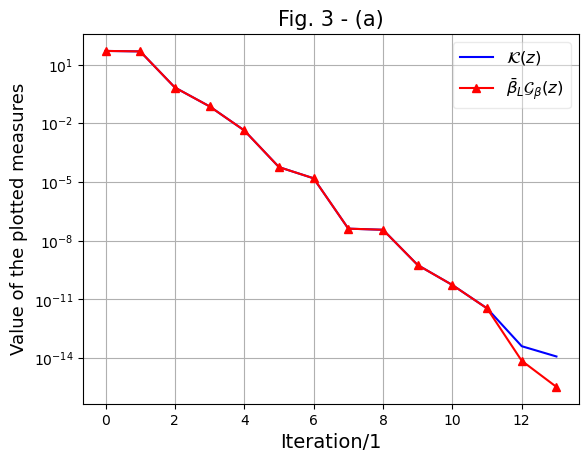

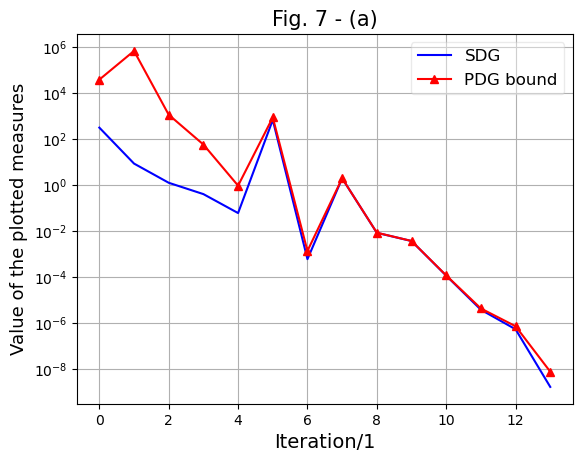

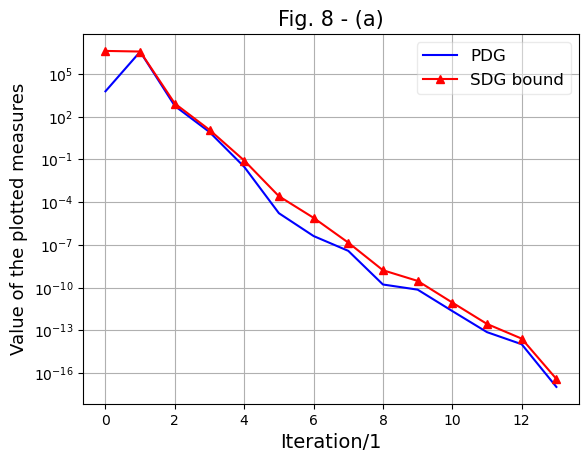

In [10]:
"""You may choose to visualize the Paper's figures only (Default) 
or all our findings by changing the argument (paper=True) to (paper=False)."""

plots = Plotter()
plots.plot_all(paper=True, prob=exp_name, OG=OG, FG=FG, KKT=KKT, PDG = PDG, SDG = SDG, OG_bounds=OG_bounds, KKT_SDG_bounds=KKT_SDG_bounds, PDG_SDG_bounds=PDG_SDG_bounds, step=result['step'])

### Experiment 2: I.I.D. Gaussian matrices 

We examine the ***LC-LS*** problem with dimensions set to $n = 20$ and $m = 10$. In this scenario, we generate independently and identically distributed (i.i.d.) Gaussian matrices $Q$ and $A$, as presented in sub-subsection **7.1.2**. That is:

\begin{equation} 
\begin{split}    
Q \in \mathbb{R}^{m \times n} ~\text{s.t.} ~\forall (i, j) \in \{ 1, \dots, m \} \times \{ 1, \dots, n \}, ~ Q_{ij} \sim \mathcal{N}(0, 1) ~ i.i.d. \\ 
    A \in \mathbb{R}^{m \times n} ~\text{s.t.} ~\forall (i, j) \in \{ 1, \dots, m \} \times \{ 1, \dots, n \}, ~ A_{ij} \sim \mathcal{N}(0, 1) ~ i.i.d. 
\end{split}
\end{equation}

In [11]:
from OptimizationProblems import LeastSquares

In [12]:
# Generating random data.
n, m = 20, 10
np.random.seed(21)
Q = np.random.randn(m, n)
c = np.random.randn(m)
A = np.random.randn(m, n)
b = np.random.randn(m)

In [13]:
# Problem initialization.
prob = LeastSquares(n, m, Q, c, A, b)
x_star, f_star, L, gamma = prob.prob_parameters(verbose=True)

Solution Existence: True 	 |Ax - b| =  2.575143099812927e-15
Lipschitz constant of the gradient of the objective function =  48.90843918315424
Lipschitz constant of the gradient of the conjugate function =  0.37064766449312686
MSR-constant, gamma =  0.01363542966298949
Problem status:  optimal
Optimal value using CVXPY =  8.538158644804047e-17


#### PDHG solution

In [14]:
# Initial values 
xo = np.zeros(n)
yo = np.random.rand(m)

In [15]:
# Initializing PDHG
Alg = PDHG(xo, yo, prob.prox_LS, A, b, x_star)

# Solving the problem
result = Alg.two_runs(stop_crt_kwargs={'f':prob.LS, 'eta_fun':prob.eta_QEBSG})


╔══════════════════════════════════════╗
║              FIRST RUN               ║
╚══════════════════════════════════════╝
Stopping Criterion: SDG
Progress:


12281it [00:22, 548.50it/s, Gap=9.98e-11]



╔══════════════════════════════════════╗
║             SECOND RUN               ║
╚══════════════════════════════════════╝
Stopping criterion: Fixed number of iterations = 12281
We append the primal and dual solutions every 6 iteration(s)
Progress:


  0%|          | 0/12281 [00:00<?, ?it/s]

#### Measures and Bounds

In [16]:
# OptimizationBounds initialization, it computes all the measures at initialization.
bounds = OptimizationBounds(result["Primal variables"], result["Dual variables"], prob.LS, prob.prox_LS, 
            prob.stationarity, prob.LSc, prob.proj_LSc, f_star, x_star, A, b, 
            L = L, Lc_grad= prob.gradc_Lipschitz(), eta_fun= prob.ETA_BETAs, gamma = gamma)

# Measures, assigning their computed values in the initialization. 
OG, FG, KKT, PDG, SDG = bounds.OG, bounds.FG, bounds.KKT, bounds.PDG, bounds.SDG_


Optimality gap:   0%|          | 0/2049 [00:00<?, ?it/s]

Feasibility gap:   0%|          | 0/2049 [00:00<?, ?it/s]

KKT error:   0%|          | 0/2049 [00:00<?, ?it/s]

PDG:   0%|          | 0/2049 [00:00<?, ?it/s]

--> Processing of the smoothing parameter, beta, for SDG and computing the corresponding QEB constant, eta.
     --> Beta is mixed of several constant values and feasibility gap.


  0%|          | 0/2049 [00:00<?, ?it/s]

In [17]:
""" Bounds: the optimality gap bounds (encapsulated in: OG_bounds) and the 
comparability bounds (encapsulated in: KKT_SDG_bounds and PDG_SDG_bounds).
"""

OG_bounds, KKT_SDG_bounds, PDG_SDG_bounds = bounds.all_bounds()


╔══════════════════════════════════════╗
║        Optimality Gap Bounds         ║
╚══════════════════════════════════════╝
* KKT approximation: Done
* SDG approximation: Done
* PDG approximation: Done

╔══════════════════════════════════════╗
║        Comparability Bounds          ║
╚══════════════════════════════════════╝
* SDG approximation for KKT: Done
* KKT approximation for SDG: Done
* PDG approximation for SDG: Done
* SDG approximation for PDG: Done


In [18]:
# Filling the dictionaries for the benchmark comparison. 
exp_name = 'I.I.D. Gaussian matrices'
OG_all[exp_name] = (OG_bounds, result['step'])

comparability = {GK: [KKT_SDG_bounds['G<K']['SDG'], KKT_SDG_bounds['G<K']['bound']],
                 KG: [KKT, KKT_SDG_bounds['K<G']],
                 GD: [PDG_SDG_bounds['G<D']['SDG'], PDG_SDG_bounds['G<D']['bound']],
                 DG: [PDG, PDG_SDG_bounds['D<G']]}
comparability_all[exp_name] = comparability

#### Figures

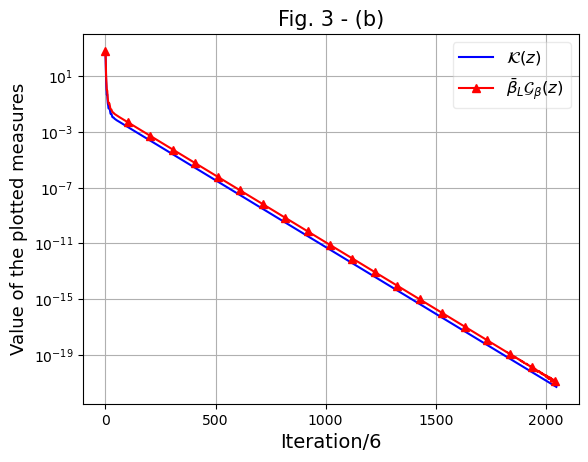

In [19]:
"""You may choose to visualize the Paper's figures only (Default) 
or all our findings by changing the argument (paper=True) to (paper=False)."""

plots = Plotter()
plots.plot_all(paper=True, prob=exp_name, OG=OG, FG=FG, KKT=KKT, PDG = PDG, SDG = SDG, OG_bounds=OG_bounds, KKT_SDG_bounds=KKT_SDG_bounds, PDG_SDG_bounds=PDG_SDG_bounds, step=result['step'])

### Experiment 3: Non-trivial covariance 

We investigate the ***LC-LS*** problem with dimensions set to $n = 20$ and $m = 10$. In this instance, we generate matrices $Q$ and $A$ with non-trivial covariance matrices, as presented in sub-subsection **7.1.2**, defined as follows:

\begin{align} 
        A = \Sigma_a X_a \hspace{0.75cm} && \hspace{0.75cm} Q = \Sigma_q X_q 
\end{align}

where
* The matrices $X_a, X_q \in \mathbb{R}^{m \times n}$ are Gaussian matrices, following the pattern established in the previous case.
* The matrices $\Sigma_a, \Sigma_q \in \mathbb{R}^{m \times m}$ serve as covariance matrices, generated using the Python built-in function [`toeplitz`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.toeplitz.html).



In [20]:
from scipy.linalg import sqrtm, toeplitz
from OptimizationProblems import LeastSquares

In [21]:
# Generating Non-Trivial Covariance random matrices
n, m = 20, 10
np.random.seed(3)
c = np.random.randn(m)
Q = sqrtm(toeplitz(0.5**np.arange(m))) @ np.random.rand(m, n)
A = sqrtm(toeplitz(0.3**np.arange(m))) @ np.random.rand(m, n)
b = np.random.randn(m)

In [22]:
# Problem initialization.
prob = LeastSquares(n, m, Q, c, A, b)
x_star, f_star, L, gamma = prob.prob_parameters(verbose=True)

Solution Existence: True 	 |Ax - b| =  6.323704530833079e-15
Lipschitz constant of the gradient of the objective function =  133.5707387210677
Lipschitz constant of the gradient of the conjugate function =  5.742824200335627
MSR-constant, gamma =  0.005692344312521514
Problem status:  optimal
Optimal value using CVXPY =  6.871370105372656e-17


#### PDHG solution

In [23]:
# Initial values 
xo = np.zeros(n)
yo = np.random.rand(m)

In [24]:
# Initializing PDHG
Alg = PDHG(xo, yo, prob.prox_LS, A, b, x_star)

# Solving the problem
result = Alg.two_runs(stop_crt_kwargs={'f':prob.LS, 'eta_fun':prob.eta_QEBSG})


╔══════════════════════════════════════╗
║              FIRST RUN               ║
╚══════════════════════════════════════╝
Stopping Criterion: SDG
Progress:


37303it [01:08, 547.06it/s, Gap=9.98e-11]



╔══════════════════════════════════════╗
║             SECOND RUN               ║
╚══════════════════════════════════════╝
Stopping criterion: Fixed number of iterations = 37303
We append the primal and dual solutions every 18 iteration(s)
Progress:


  0%|          | 0/37303 [00:00<?, ?it/s]

#### Measures and Bounds

In [25]:
# OptimizationBounds initialization, it computes all the measures at initialization.
bounds = OptimizationBounds(result["Primal variables"], result["Dual variables"], prob.LS, prob.prox_LS, 
            prob.stationarity, prob.LSc, prob.proj_LSc, f_star, x_star, A, b, 
            L = L, Lc_grad= prob.gradc_Lipschitz(), eta_fun= prob.ETA_BETAs, gamma = gamma)

# Measures, assigning their computed values in the initialization. 
OG, FG, KKT, PDG, SDG = bounds.OG, bounds.FG, bounds.KKT, bounds.PDG, bounds.SDG_

Optimality gap:   0%|          | 0/2075 [00:00<?, ?it/s]

Feasibility gap:   0%|          | 0/2075 [00:00<?, ?it/s]

KKT error:   0%|          | 0/2075 [00:00<?, ?it/s]

PDG:   0%|          | 0/2075 [00:00<?, ?it/s]

--> Processing of the smoothing parameter, beta, for SDG and computing the corresponding QEB constant, eta.
     --> Beta is mixed of several constant values and feasibility gap.


  0%|          | 0/2075 [00:00<?, ?it/s]

In [26]:
""" Bounds: the optimality gap bounds (encapsulated in: OG_bounds) and the 
comparability bounds (encapsulated in: KKT_SDG_bounds and PDG_SDG_bounds).
"""

OG_bounds, KKT_SDG_bounds, PDG_SDG_bounds = bounds.all_bounds()


╔══════════════════════════════════════╗
║        Optimality Gap Bounds         ║
╚══════════════════════════════════════╝
* KKT approximation: Done
* SDG approximation: Done
* PDG approximation: Done

╔══════════════════════════════════════╗
║        Comparability Bounds          ║
╚══════════════════════════════════════╝
* SDG approximation for KKT: Done
* KKT approximation for SDG: Done
* PDG approximation for SDG: Done
* SDG approximation for PDG: Done


In [27]:
# Filling the dictionaries for the benchmark comparison. 
exp_name = 'Non-trivial covariance'
OG_all[exp_name] = (OG_bounds, result['step'])

comparability = {GK: [KKT_SDG_bounds['G<K']['SDG'], KKT_SDG_bounds['G<K']['bound']],
                 KG: [KKT, KKT_SDG_bounds['K<G']],
                 GD: [PDG_SDG_bounds['G<D']['SDG'], PDG_SDG_bounds['G<D']['bound']],
                 DG: [PDG, PDG_SDG_bounds['D<G']]}
comparability_all[exp_name] = comparability

#### Figures

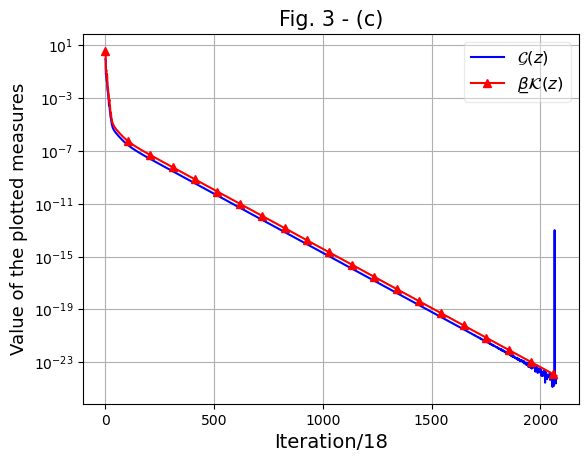

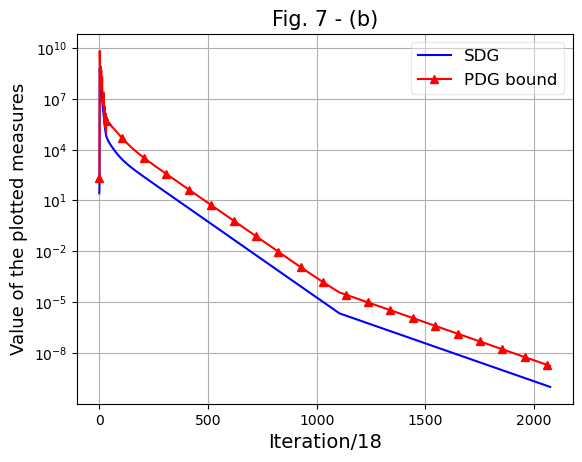

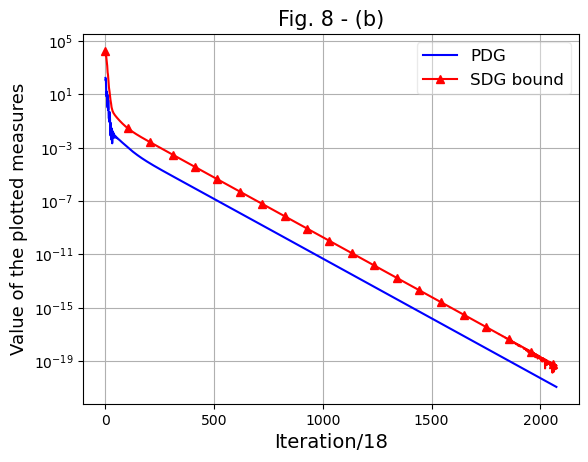

In [28]:
"""You may choose to visualize the Paper's figures only (Default) 
or all our findings by changing the argument (paper=True) to (paper=False)."""

plots = Plotter()
plots.plot_all(paper=True, prob=exp_name, OG=OG, FG=FG, KKT=KKT, PDG = PDG, SDG = SDG, OG_bounds=OG_bounds, KKT_SDG_bounds=KKT_SDG_bounds, PDG_SDG_bounds=PDG_SDG_bounds, step=result['step'])

### Experiment 4: Distributed optimization

We examine the unconstrained optimization problem presented as follows:

\begin{equation} 
    \min_{x \in \mathbb{R}^n} ~ \frac{1}{2} \sum_{i = 1}^M  \left\| Q_ix - c_i\right\|^2 
\end{equation}

- In this formulation, for each $i \in \{ 1, \dots, M \} $, the matrix $Q_i \in \mathbb{R}^{m \times n}$ and the vector $c_i \in \mathbb{R}^m$ are real data sourced from the [`bodyfat`](https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/regression.html) dataset. This data comprises 252 data-points, each characterized by 14 features. In our case, we divide the dataset into $M = 3, n = 14$, and $m = 84$.

- As presented in Sub-section **7.2**, we can re-formulate the unconstrained problem into a constrained one: 

    \begin{equation} 
        \min_{X \in \mathbb{R}^{Mn}} ~ \frac{1}{2} \left\| \mathbf{Q} X  - \mathbf{c} \right\|^2 \hspace{1cm} \text{subject to} \hspace{1cm} AX = 0
    \end{equation}

    where, $X_{Mn} := \begin{bmatrix} x_1 & \dots & x_M \end{bmatrix}^T$, $\mathbf{c}_{Mm} := \begin{bmatrix} c_1 & \dots & c_M \end{bmatrix}^T$, and 

    \begin{align*}
        \mathbf{Q}_{Mm \times Mn} := \begin{bmatrix}
            Q_1 & \mathbf{0}_{m \times n} & \dots & \mathbf{0}_{m \times n} \\ \mathbf{0}_{m \times n} & Q_2 & \dots & \mathbf{0}_{m \times n} \\ \vdots & \dots & \ddots & \dots \\ \mathbf{0}_{m \times n} & \dots & \mathbf{0}_{m \times n} & Q_M
        \end{bmatrix} && A_{(M-1)n \times Mn} := \begin{bmatrix}
            \mathbf{Id}_n & -\mathbf{Id}_n & \mathbf{0}_n & \dots & \mathbf{0}_n \\ 
            \mathbf{0}_n  & \mathbf{Id}_n & -\mathbf{Id}_n  & \dots & \mathbf{0}_n \\
            \vdots & \dots & \ddots & \ddots & \dots\\
            \mathbf{0}_n & \dots &  \mathbf{0}_n & \mathbf{Id}_n & -\mathbf{Id}_n 
        \end{bmatrix} 
    \end{align*}

- Moreover, thanks to the unconstrained problem, the minimizer $x^{\star}$ can be easily found: 

\begin{equation}  \left(\sum_{i = 1}^M Q^T_iQ_i\right)x^{\star} = \sum_{i = 1}^M Q^T_i c_i  \end{equation}

In [29]:
from OptimizationProblems import DistributedOPT

In [30]:
# Data.
M, nbdata, nbfeatures = 3, 252, 14
data = 'bodyfat_scale.txt'

# Problem initialization.
prob = DistributedOPT(data, M, nbdata, nbfeatures)
x_star, f_star, L, gamma = prob.prob_parameters(verbose=True)

Solution Existence: True 	 |Ax - b| =  0.0
Lipschitz constant of the gradient of the objective function =  220.6008255002165
Lipschitz constant of the gradient of the conjugate function =  12.169509417056403
MSR-constant, gamma =  0.005301463151961919
Analytical optimal value =  1.7296360586967003


#### PDHG solution

In [31]:
# Initial values 
xo = np.random.rand(M*nbfeatures)
yo = np.random.rand((M-1)*nbfeatures)

In [32]:
# Initializing PDHG
Alg = PDHG(xo, yo, prob.prox_LS, prob.A, prob.b, x_star)

# Solving the problem
result = Alg.two_runs(stop_crt = 'KKT error', stop_crt_kwargs={'f': prob.LS, 'stationarity': prob.stationarity, 'gamma': prob.gamma_MSR()})


╔══════════════════════════════════════╗
║              FIRST RUN               ║
╚══════════════════════════════════════╝
Stopping Criterion: KKT error
Progress:


7156it [00:09, 736.63it/s, Gap=9.98e-11]



╔══════════════════════════════════════╗
║             SECOND RUN               ║
╚══════════════════════════════════════╝
Stopping criterion: Fixed number of iterations = 7156
We append the primal and dual solutions every 3 iteration(s)
Progress:


  0%|          | 0/7156 [00:00<?, ?it/s]

#### Measures and Bounds

In [33]:
# OptimizationBounds initialization, it computes all the measures at initialization.
bounds = OptimizationBounds(result["Primal variables"], result["Dual variables"], prob.LS, prob.prox_LS, 
            prob.stationarity, prob.LSc, prob.proj_LSc, f_star, x_star, prob.A, prob.b, 
            L = L, Lc_grad= prob.gradc_Lipschitz(), eta_fun= prob.ETA_BETAs, gamma = gamma)

# Measures, assigning their computed values in the initialization. 
OG, FG, KKT, PDG, SDG = bounds.OG, bounds.FG, bounds.KKT, bounds.PDG, bounds.SDG_

Optimality gap:   0%|          | 0/2388 [00:00<?, ?it/s]

Feasibility gap:   0%|          | 0/2388 [00:00<?, ?it/s]

KKT error:   0%|          | 0/2388 [00:00<?, ?it/s]

PDG:   0%|          | 0/2388 [00:00<?, ?it/s]

--> Processing of the smoothing parameter, beta, for SDG and computing the corresponding QEB constant, eta.
     --> Beta is mixed of several constant values and feasibility gap.


  0%|          | 0/2388 [00:00<?, ?it/s]

In [34]:
""" Bounds: the optimality gap bounds (encapsulated in: OG_bounds) and the 
comparability bounds (encapsulated in: KKT_SDG_bounds and PDG_SDG_bounds).
"""

OG_bounds, KKT_SDG_bounds, PDG_SDG_bounds = bounds.all_bounds()


╔══════════════════════════════════════╗
║        Optimality Gap Bounds         ║
╚══════════════════════════════════════╝
* KKT approximation: Done
* SDG approximation: Done
* PDG approximation: Done

╔══════════════════════════════════════╗
║        Comparability Bounds          ║
╚══════════════════════════════════════╝
* SDG approximation for KKT: Done
* KKT approximation for SDG: Done
* PDG approximation for SDG: Done
* SDG approximation for PDG: Done


In [35]:
# Filling the dictionaries for the benchmark comparison. 
exp_name = 'Distributed optimization'
OG_all[exp_name] = (OG_bounds, result['step'])

comparability = {GK: [KKT_SDG_bounds['G<K']['SDG'], KKT_SDG_bounds['G<K']['bound']],
                 KG: [KKT, KKT_SDG_bounds['K<G']],
                 GD: [PDG_SDG_bounds['G<D']['SDG'], PDG_SDG_bounds['G<D']['bound']],
                 DG: [PDG, PDG_SDG_bounds['D<G']]}
comparability_all[exp_name] = comparability

#### Figures

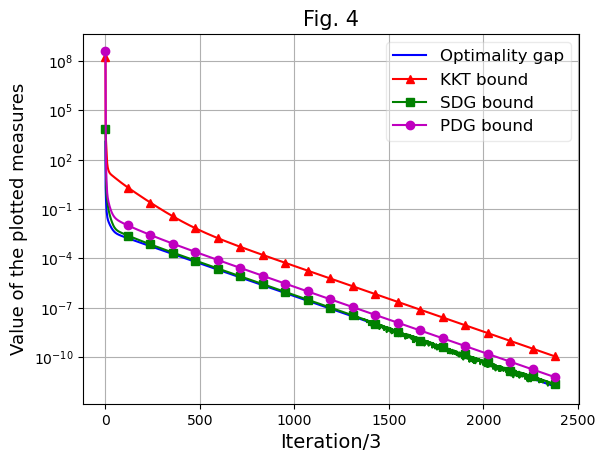

In [36]:
"""You may choose to visualize the Paper's figures only (Default) 
or all our findings by changing the argument (paper=True) to (paper=False)."""

plots = Plotter()
plots.plot_all(paper=True, prob=exp_name, OG=OG, FG=FG, KKT=KKT, PDG = PDG, SDG = SDG, OG_bounds=OG_bounds, KKT_SDG_bounds=KKT_SDG_bounds, PDG_SDG_bounds=PDG_SDG_bounds, step=result['step'])

## Quadratic Programming (QP)

As we have mentioned, our theoretical findings have primarily focused on optimization problems under equality affine constraints. However, in this experiment, we aim to extend the applicability of our theoretical insights to address optimization problems that incorporate inequality constraints. Therefore, we consider the same **LC-LS** problem as discussed earlier, but now incorporating the additional requirement of non-negativity constraints on the weights. 

### Experiment 5

We consider the following *Quadratic Programming* problem: 

\begin{equation} 
\begin{split}
    \min_{x \in \mathbb{R}^n}  \frac{1}{2} & \|Qx - c\|^2 \\ 
    \text{s.t.} ~~ & Ax = b \\ 
     & \hspace{0.3cm} x \geq 0
\end{split}
\end{equation}

In Sub-section **7.3**, we show how one can re-formulate this problem to project it into our framework of interest. In short, we first encapsulate the non-negativity constraint by introducing an indicator function withing the objective function. Subsequently, we introduce an additional variable, $\tilde{x}$, and incorporate an extra constraint, $x = \tilde{x}$. That is: 

\begin{equation}
\begin{split}
    \min_{X \in \mathbb{R}^{2n}}  F(X) = \frac{1}{2}  \|Qx - c\|^2 & + \imath_{\mathbb{R}_+^n}(\tilde{x})\\ 
    \text{subject to} \hspace{1cm}  \tilde{A}X = B& 
\end{split}
\end{equation}
where 
\begin{align}
    X := \begin{bmatrix}
        x \\ \tilde{x}
    \end{bmatrix} && \tilde{A} := \begin{bmatrix}
        A & 0 \\ \mathbf{Id} & - \mathbf{Id} 
    \end{bmatrix} && B := \begin{bmatrix}
        b \\ 0
    \end{bmatrix}
\end{align}

This re-formulation projects the problem into our framework, and would render the computation more manageable. 

In [37]:
from scipy.linalg import sqrtm, toeplitz
from PDHG import PDHG3
from OptimizationProblems import QuadraticProgramming

In [38]:
# Generating Non-Trivial Covariance random matrices
n, m = 20, 10
np.random.seed(50)
Q = sqrtm(toeplitz(0.5**np.arange(m))) @ np.random.rand(m, n)
c = np.random.randn(m)
A = sqrtm(toeplitz(0.3**np.arange(m))) @ np.random.rand(m, n)
b = np.zeros(m)

A_tilde = np.block([[A, np.zeros((m , n))], [np.eye(n), -1*np.eye(n)]])
B = np.hstack((b, np.zeros(n)))

In [39]:
# Problem initialization.
prob = QuadraticProgramming(n, m, Q, c, A_tilde, B)
x_star, f_star, L, gamma = prob.prob_parameters(verbose=True)

Solution Existence: True 	 |Ax - b| =  0.0
Lipschitz constant of the gradient of the objective function =  inf
Lipschitz constant of the gradient of the conjugate function =  3.4541362356843726
MSR-constant, gamma =  1e-08
Problem status:  optimal
Optimal value using CVXPY =  4.635113650393752


#### PDHG solution

In [40]:
# Initial values 
xo = np.random.rand(2*n)
yo = np.random.rand(n + m)

In [41]:
# Initializing PDHG
Alg = PDHG3(xo, yo, prob.prox_objective, A_tilde, B, x_star = np.tile(x_star, 2))

# Solving the problem
result = Alg.two_runs(stop_crt_kwargs={'f':prob.objective, 'eta_fun':prob.eta_QEBSG})


╔══════════════════════════════════════╗
║              FIRST RUN               ║
╚══════════════════════════════════════╝
Stopping Criterion: SDG
Progress:


4335it [00:04, 1013.96it/s, Gap=9.88e-11]



╔══════════════════════════════════════╗
║             SECOND RUN               ║
╚══════════════════════════════════════╝
Stopping criterion: Fixed number of iterations = 4335
We append the primal and dual solutions every 2 iteration(s)
Progress:


  0%|          | 0/4335 [00:00<?, ?it/s]

#### Measures and Bounds 

In [42]:
# OptimizationBounds initialization, it computes all the measures at initialization.
bounds = OptimizationBounds(result["Primal bar variables"], result["Dual variables"], prob.objective, prob.prox_objective, 
            prob.stationarity, prob.objective_c, prob.proj_objective_c, f_star, x_star, A_tilde, B, 
            L = L, Lc_grad= prob.gradc_Lipschitz(), eta_fun= prob.ETA_BETAs, gamma = gamma)

# Measures, assigning their computed values in the initialization. 
OG, FG, KKT, PDG, SDG = bounds.OG, bounds.FG, bounds.KKT, bounds.PDG, bounds.SDG_

Optimality gap:   0%|          | 0/2170 [00:00<?, ?it/s]

Feasibility gap:   0%|          | 0/2170 [00:00<?, ?it/s]

KKT error:   0%|          | 0/2170 [00:00<?, ?it/s]

PDG:   0%|          | 0/2170 [00:00<?, ?it/s]

--> Processing of the smoothing parameter, beta, for SDG and computing the corresponding QEB constant, eta.
     --> Beta is mixed of several constant values and feasibility gap.


  0%|          | 0/2170 [00:00<?, ?it/s]

In [43]:
""" Bounds: the optimality gap bounds (encapsulated in: OG_bounds) and the 
comparability bounds (encapsulated in: KKT_SDG_bounds and PDG_SDG_bounds).
"""

OG_bounds, KKT_SDG_bounds, PDG_SDG_bounds = bounds.all_bounds()


╔══════════════════════════════════════╗
║        Optimality Gap Bounds         ║
╚══════════════════════════════════════╝
* KKT approximation: Done
* SDG approximation: Done
* PDG approximation: Done

╔══════════════════════════════════════╗
║        Comparability Bounds          ║
╚══════════════════════════════════════╝
* SDG approximation for KKT: Done
* KKT approximation for SDG: Done
* PDG approximation for SDG: Done
* SDG approximation for PDG: Done


In [44]:
# Filling the dictionaries for the benchmark comparison. 
exp_name = 'Quadratic programming'
OG_all[exp_name] = (OG_bounds, result['step'])

comparability = {GK: [KKT_SDG_bounds['G<K']['SDG'], KKT_SDG_bounds['G<K']['bound']],
                 KG: [KKT, KKT_SDG_bounds['K<G']],
                 GD: [PDG_SDG_bounds['G<D']['SDG'], PDG_SDG_bounds['G<D']['bound']],
                 DG: [PDG, PDG_SDG_bounds['D<G']]}
comparability_all[exp_name] = comparability

#### Figures

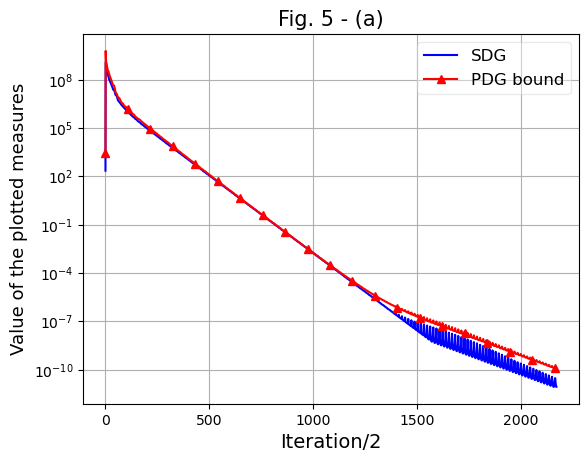

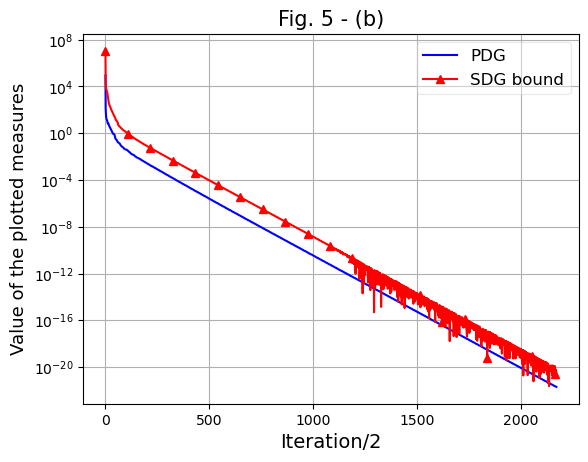

In [45]:
"""You may choose to visualize the Paper's figures only (Default) 
or all our findings by changing the argument (paper=True) to (paper=False)."""

plots = Plotter()
plots.plot_all(paper=True, prob=exp_name, OG=OG, FG=FG, KKT=KKT, PDG = PDG, SDG = SDG, OG_bounds=OG_bounds, KKT_SDG_bounds=KKT_SDG_bounds, PDG_SDG_bounds=PDG_SDG_bounds, step=result['step'])

## Basis pursuit

Our last experiment, as presented in Sub-section **7.4**, involves a non-smooth convex minimization problem known as the ***Basis Pursuit*** problem. It aims to minimize the $\ell_1$ norm while satisfying a system of linear equation.

The primary objective of this experiment is to highlight the superior stability of the *Smoothed duality Gap* compared to the *Karush–Kuhn–Tucker error*, as will be demonstrated subsequently.

This experiment shows that the *KKT error* is **algorithm-dependant**. You will see that the KKT error will not converge when employing the PDHG algorithm presented above to compute the KKT error. However, as explained in Sub-section **7.4**, if we employ a different version of PDHG, it does converge. 

Here are the two versions of PDHG: 

<center>

|        Version 1       |      Interpretation       |
|:----------------------:|:-------------------------:|
|$\bar{x}_{k+1} = \mathrm{prox}_{\tau f}\left(x_k - \tau A^Ty_k\right)$ |Primal Forward-Backward step   |
|$\bar{y}_{k+1} = y_k + \sigma \left(A\bar{x}_{k+1} - b\right)$ |Dual Forward-Backward step    |
|$x_{k+1} = \bar{x}_{k+1} - \tau A^T\left(\bar{y}_{k+1} - y_k\right)$ |Primal Extrapolation step   |
|$y_{k+1} = \bar{y}_{k+1}$               |Dual Extrapolation step        |

|        Version 2       |       Interpretation        |
|:----------------------:|:---------------------------:|
| $\bar{y}_{k+1} = y_k + \sigma \left(Ax_{k} - b\right)$ |    Dual Forward-Backward step    |
| $\bar{x}_{k+1} = \mathrm{prox}_{\tau f}\left(x_k - \tau A^T\bar{y}_{k+1}\right)$ |  Primal Forward-Backward step  |
| $y_{k+1} = \bar{y}_{k+1} + \sigma A\left(\bar{x}_{k+1} - x_k\right)$ |    Dual Extrapolation step    |
|               $x_{k+1} = \bar{x}_{k+1}$               |      Primal Extrapolation step      |

</center>



### Experiment 6

*Basis Pursuit* is mathematically formulated as: 

\begin{equation}
        \min_{x \in \mathbb{R}^n} ~ \|x\|_1 \hspace{1cm} \text{subject to} \hspace{1cm}  Ax = b
\end{equation}

Here, we set $n = 20$ and $m = 10$, and generate an i.i.d. Gaussian matrix $A \in \mathbb{R}^{m \times n}$ and vector $b \in \mathbb{R}^m$.

In [46]:
from PDHG import PDHG2
from OptimizationProblems import BasisPursuit

In [47]:
# Data.
n, m = 20, 10
np.random.seed(6)
A = np.random.randn(m, n)
b = np.random.randn(m)

# Problem initialization.
prob = BasisPursuit(n, m, A, b)
x_star, f_star, L, gamma = prob.prob_parameters(verbose=True)

Solution Existence: True 	 |Ax - b| =  3.3929985021466104e-15
Lipschitz constant of the gradient of the objective function =  inf
MSR-constant, gamma =  1e-08
Problem status:  optimal
Optimal value using CVXPY =  4.029761700248781


#### PDHG version 1 solution

In [48]:
# Initial values 
xo = np.zeros(n)
yo = np.random.rand(m)

In [49]:
# Initializing version 1 of PDHG
Alg = PDHG(xo, yo, prob.prox_L1N, A, b, x_star)

# Solving the problem
result = Alg.two_runs(stop_crt_kwargs={'f':prob.L1N, 'eta_fun':prob.eta_QEBSG})


╔══════════════════════════════════════╗
║              FIRST RUN               ║
╚══════════════════════════════════════╝
Stopping Criterion: SDG
Progress:


9079it [00:06, 1347.27it/s, Gap=9.97e-11]



╔══════════════════════════════════════╗
║             SECOND RUN               ║
╚══════════════════════════════════════╝
Stopping criterion: Fixed number of iterations = 9079
We append the primal and dual solutions every 4 iteration(s)
Progress:


  0%|          | 0/9079 [00:00<?, ?it/s]

#### PDHG version 2 solution

In [50]:
# Initializing version 2 of PDHG
Alg2 = PDHG2(xo, yo, prob.prox_L1N, A, b, x_star)

# Solving the problem
result2 = Alg2.two_runs(stop_crt_kwargs={'f':prob.L1N, 'eta_fun':prob.eta_QEBSG}) 


╔══════════════════════════════════════╗
║              FIRST RUN               ║
╚══════════════════════════════════════╝
Stopping Criterion: SDG
Progress:


9121it [00:06, 1375.58it/s, Gap=9.99e-11]



╔══════════════════════════════════════╗
║             SECOND RUN               ║
╚══════════════════════════════════════╝
Stopping criterion: Fixed number of iterations = 9121
We append the primal and dual solutions every 4 iteration(s)
Progress:


  0%|          | 0/9121 [00:00<?, ?it/s]

#### Measures computed at the solutions of both versions

In [51]:
# OptimizationBounds initialization, it computes all the measures at initialization.

# Version 1 
print("""
╔══════════════════════════════════════╗
║          Version 1 Measures          ║
╚══════════════════════════════════════╝""")
bounds = OptimizationBounds(result["Primal variables"], result["Dual variables"], prob.L1N, prob.prox_L1N, 
            prob.stationarity, prob.L1Nc, prob.proj_L1Nc, f_star, x_star, A, b, 
            L=L, Lc=0, eta_fun= prob.ETA_BETAs, gamma=gamma)

# Version 2
print("""
╔══════════════════════════════════════╗
║          Version 2 Measures          ║
╚══════════════════════════════════════╝""")
bounds2 = OptimizationBounds(result2["Primal variables"], result2["Dual variables"], prob.L1N, prob.prox_L1N, 
            prob.stationarity, prob.L1Nc, prob.proj_L1Nc, f_star, x_star, A, b, 
            L=L, Lc=0, eta_fun=prob.ETA_BETAs, gamma=gamma)


╔══════════════════════════════════════╗
║          Version 1 Measures          ║
╚══════════════════════════════════════╝


Optimality gap:   0%|          | 0/2272 [00:00<?, ?it/s]

Feasibility gap:   0%|          | 0/2272 [00:00<?, ?it/s]

KKT error:   0%|          | 0/2272 [00:00<?, ?it/s]

PDG:   0%|          | 0/2272 [00:00<?, ?it/s]

--> Processing of the smoothing parameter, beta, for SDG and computing the corresponding QEB constant, eta.
     --> Beta is mixed of several constant values and feasibility gap.


  0%|          | 0/2272 [00:00<?, ?it/s]


╔══════════════════════════════════════╗
║          Version 2 Measures          ║
╚══════════════════════════════════════╝


Optimality gap:   0%|          | 0/2283 [00:00<?, ?it/s]

Feasibility gap:   0%|          | 0/2283 [00:00<?, ?it/s]

KKT error:   0%|          | 0/2283 [00:00<?, ?it/s]

PDG:   0%|          | 0/2283 [00:00<?, ?it/s]

--> Processing of the smoothing parameter, beta, for SDG and computing the corresponding QEB constant, eta.
     --> Beta is mixed of several constant values and feasibility gap.


  0%|          | 0/2283 [00:00<?, ?it/s]

In [52]:
# Measures, assigning their computed values in the initialization. 

# Version 1 
OG, FG, KKT, PDG, SDG = bounds.OG, bounds.FG, bounds.KKT, bounds.PDG, bounds.SDG_

# Version 2
KKT2, SDG2 = bounds2.KKT, bounds2.SDG_
min_ite = min(len(KKT), len(KKT2))


#### Bounds computed at the solution of version 2

In [53]:
""" Bounds: the optimality gap bounds (encapsulated in: OG_bounds) and the 
comparability bounds (encapsulated in: KKT_SDG_bounds and PDG_SDG_bounds).
"""

OG_bounds, KKT_SDG_bounds, PDG_SDG_bounds = bounds.all_bounds()


╔══════════════════════════════════════╗
║        Optimality Gap Bounds         ║
╚══════════════════════════════════════╝
* KKT approximation: Done
* SDG approximation: Done
* PDG approximation: Done

╔══════════════════════════════════════╗
║        Comparability Bounds          ║
╚══════════════════════════════════════╝
* SDG approximation for KKT: Done
* KKT approximation for SDG: Done
* PDG approximation for SDG: Done
* SDG approximation for PDG: Done


In [54]:
# Filling the dictionaries for the benchmark comparison. 
exp_name = 'Basis Pursuit'
OG_all[exp_name] = (OG_bounds, result['step'])

comparability = {GK: [KKT_SDG_bounds['G<K']['SDG'], KKT_SDG_bounds['G<K']['bound']],
                 KG: [KKT, KKT_SDG_bounds['K<G']],
                 GD: [PDG_SDG_bounds['G<D']['SDG'], PDG_SDG_bounds['G<D']['bound']],
                 DG: [PDG, PDG_SDG_bounds['D<G']]}
comparability_all[exp_name] = comparability

#### Figures

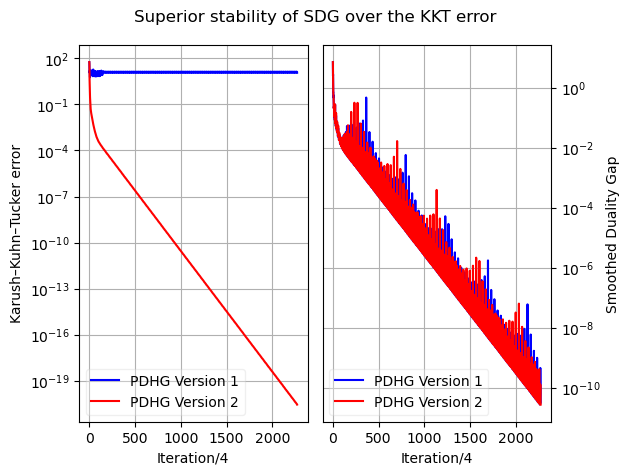

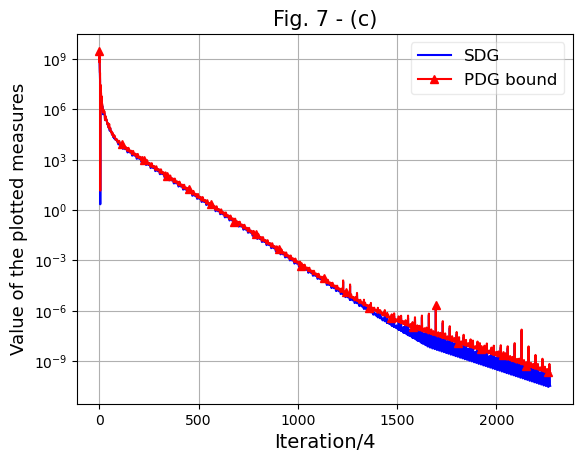

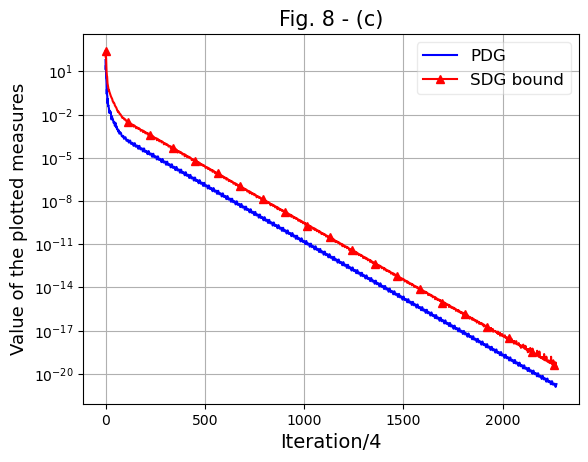

In [55]:
"""You may choose to visualize the Paper's figures only (Default) 
or all our findings by changing the argument (paper=True) to (paper=False)."""

plots = Plotter()
plots.plot_all(paper=True, prob=exp_name, OG=OG, FG=FG, KKT=KKT, PDG=PDG, SDG = SDG, OG_bounds=OG_bounds, KKT_SDG_bounds=KKT_SDG_bounds, PDG_SDG_bounds=PDG_SDG_bounds, step=result['step'], min_ite=min_ite, BP_kwargs={'KKT2':KKT2, 'SDG2':SDG2})

## Benchmark Comparison 

Lastly, we conduct a benchmark analysis by applying our findings to the six experiments previously discussed.

* Initially, we report the number of iterations required by each problem to identify an $\varepsilon = 10^{−8}$ solution, employing various stopping criteria. 

    Note that, the same data is used to compute the 3 measures (*KKT error*, *SDG*, and *PDG*) for each experiment. It provides additional evidence, showing that the smoothed duality gap consistently achieves $\varepsilon$-solutions with fewer iterations across nearly all of our experiments, thus demonstrating its superior efficiency.

In [56]:
OG_table = find_iter(OG_all, 1e-8)
OG_table

,KKT error,SDG,PDG
One-dimensional,12.0,11,13
I.I.D. Gaussian matrices,5334.0,5244,11538
Non-trivial covariance,14274.0,13968,31806
Distributed optimization,5652.0,4014,4659
Quadratic programming,3492.0,3172,3358
Basis Pursuit,inf,6920,7196


* Subsequently, we demonstrate the tightness of our comparability bounds, as outlined in Section **4**, across each experiment. This is achieved by presenting the average and standard deviation of the ratio of each result, more specifically, for the bound $\mathcal{M}_1 \leq \mathcal{W}(\mathcal{M}_2)$. The displayed values represent the average and standard deviation of the term $\frac{\mathcal{W}(\mathcal{M}_2)}{\mathcal{M}_1}$.

In [57]:
comparability_table = avg_sd(comparability_all)
comparability_table

/Users/iyadwalwil/anaconda3/lib/python3.10/site-packages/numpy/core/_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


,SDG ≤ KKT,KKT ≤ SDG,SDG ≤ PDG,PDG ≤ SDG
One-dimensional,2.56 ± 1.56,0.87 ± 0.31,5.74e+03 ± 2.04e+04,54.44 ± 176.07
I.I.D. Gaussian matrices,2.02 ± 0.06,2.2 ± 0.05,101.65 ± 25.13,5.23 ± 5.43
Non-trivial covariance,2.03 ± 0.34,5.44 ± 0.47,15.21 ± 2.47,42.19 ± 35.72
Distributed optimization,3.72 ± 3.9,2.12e+08 ± 2.59e+09,11.8 ± 9.15,28.17 ± 10.75
Quadratic programming,1.25 ± 2.03,inf ± nan,4.21 ± 4.7,32.3 ± 20.98
Basis Pursuit,7.29e+09 ± 1.46e+11,inf ± nan,2.49 ± 2.02,20.52 ± 4.25
